# Algae Prediction Results

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.model_selection import GridSearchCV

from main import prep_insitu, prep_sat, experiment_dataset, experiment_model

## Data

In [4]:
insitu = pd.read_csv('complete_in-situ.csv', low_memory=False)
sat = pd.read_csv('larger_landsat.csv', low_memory=False)
insitu = prep_insitu(insitu)
sat = prep_sat(sat)

log_chloro = np.log(insitu['chlorophyll'])
insitu['chlorophyll'] = log_chloro
insitu = insitu[np.isfinite(log_chloro)]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Feature Importance

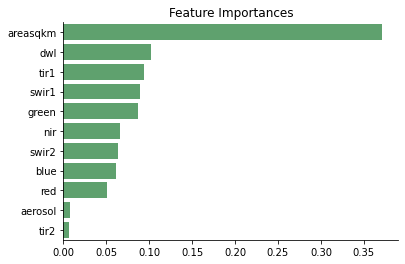

In [5]:
model = experiment_model('random_forest')
variables = ['red', 'green', 'blue', 'nir', 'aerosol', 'areasqkm',
             'dwl', 'swir1', 'swir2', 'tir1', 'tir2']
X_train, y_train = experiment_dataset(
    insitu,
    sat,
    subset=variables,
    merge_thresh=3
)
model.fit(X_train, y_train)
feature_importances = model.feature_importances_


importance_series = pd.Series(dict(zip(variables, feature_importances)))
importance_series = importance_series.sort_values(ascending=False)
sb.barplot(
    y=importance_series.index,
    x=importance_series.values,
    color='xkcd:algae'
)
sb.despine()
plt.title('Feature Importances')
plt.savefig('figures/feature_importances.png', dpi=200, bbox_inches='tight')
plt.show()

## Model hyperparameters

In [59]:
param_grid = {'max_depth': np.linspace(10, 150, 4).astype(int),
              'max_features': ['auto', 'sqrt', 'log'],
              'min_samples_leaf': [1, 2, 4, 8],
              'min_samples_split': [2, 5, 10, 15],
              'n_estimators': np.linspace(100, 500, 4).astype(int)}
cv = GridSearchCV(
    model,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...te=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

In [87]:
cv_results = pd.DataFrame(cv.cv_results_)

In [88]:
cv_results['mean_test_score'] = np.exp(cv_results['mean_test_score'].abs())

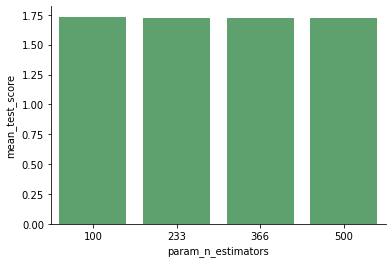

In [89]:
sb.barplot(
    data=cv_results.groupby('param_n_estimators')['mean_test_score'].min().abs().reset_index(),
    y='mean_test_score',
    x='param_n_estimators',
    color='xkcd:algae'
)
sb.despine()
plt.show()

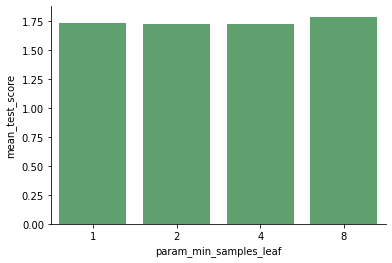

In [90]:
sb.barplot(
    data=cv_results.groupby('param_min_samples_leaf')['mean_test_score'].min().abs().reset_index(),
    y='mean_test_score',
    x='param_min_samples_leaf',
    color='xkcd:algae'
)
sb.despine()
plt.show()

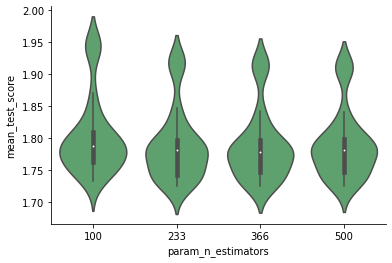

In [91]:
sb.violinplot(
    data=cv_results,
    x='param_n_estimators',
    y='mean_test_score',
    color='xkcd:algae'
)
sb.despine()
plt.show()

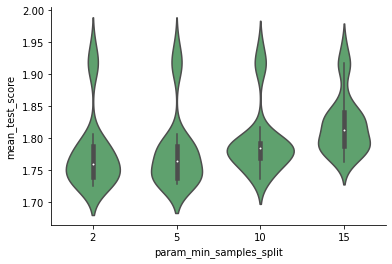

In [92]:
sb.violinplot(
    data=cv_results,
    x='param_min_samples_split',
    y='mean_test_score',
    color='xkcd:algae'
)
sb.despine()
plt.show()

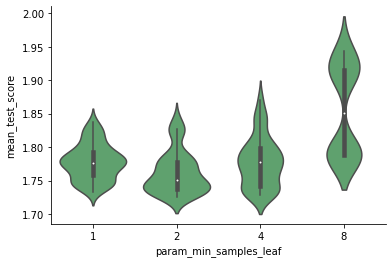

In [93]:
sb.violinplot(
    data=cv_results,
    x='param_min_samples_leaf',
    y='mean_test_score',
    color='xkcd:algae'
)
sb.despine()
plt.show()

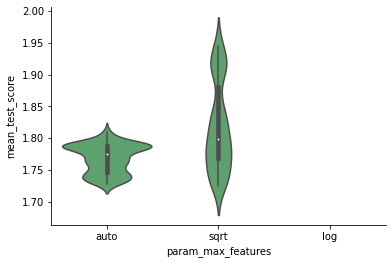

In [94]:
sb.violinplot(
    data=cv_results,
    x='param_max_features',
    y='mean_test_score',
    color='xkcd:algae'
)
sb.despine()
plt.show()

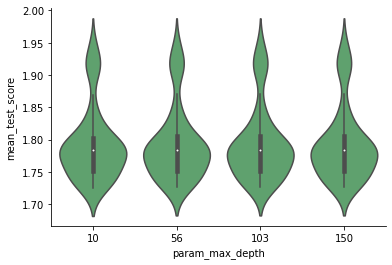

In [95]:
sb.violinplot(
    data=cv_results,
    x='param_max_depth',
    y='mean_test_score',
    color='xkcd:algae'
)
sb.despine()
plt.show()

## Model performance
To analyze the model performance, we'll read in the results generated by `main.py`.

In [99]:
results = pd.read_csv('results.csv')
results.head()

,model_type,subset,merge_thresh,mse
0,random_forest,0,0,2.313906
1,random_forest,0,1,3.303723
2,random_forest,0,2,3.613094
3,random_forest,0,3,2.240282
4,random_forest,0,4,2.963123


In [100]:
results.loc[results['mse'].idxmin()]

model_type      random_forest
subset                      5
merge_thresh                3
mse                   1.72256
Name: 58, dtype: object

In [50]:
current_palette = sb.color_palette()
palette = {'random_forest': current_palette[0],
           'gradient_boost': current_palette[1],
           'xgboost': current_palette[2]}

### How does merge threshold affect model performance?

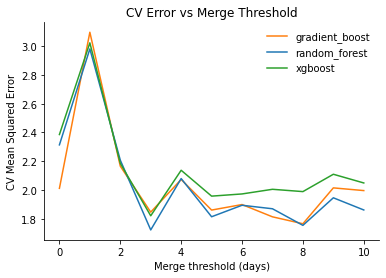

In [51]:
merge_thresh_results = results \
    .groupby(['model_type', 'merge_thresh'])['mse'] \
    .min() \
    .reset_index() \
    .sort_values('model_type')
sb.lineplot(
    data=merge_thresh_results,
    x='merge_thresh',
    y='mse',
    hue='model_type',
    palette=palette,
    ci=None
)
plt.legend(frameon=False)
sb.despine()
plt.title('CV Error vs Merge Threshold')
plt.xlabel('Merge threshold (days)')
plt.ylabel('CV Mean Squared Error')
plt.savefig('figures/merge_thresh.png', dpi=200, bbox_inches='tight')
plt.show()

### How does the feature subset affect model performance?

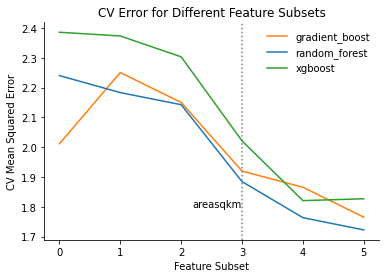

In [59]:
subset_results = results \
    .groupby(['model_type', 'subset'])['mse'] \
    .min() \
    .reset_index() \
    .sort_values('model_type')
sb.lineplot(
    data=subset_results,
    x='subset',
    y='mse',
    hue='model_type',
    palette=palette,
    ci=None,
)
plt.axvline(3, linestyle='dotted', color='grey')
plt.text(3, 1.8, 'areasqkm', ha='right')
plt.legend(frameon=False)
sb.despine()
plt.title('CV Error for Different Feature Subsets')
plt.xlabel('Feature Subset')
plt.ylabel('CV Mean Squared Error')
plt.savefig('figures/subset.png', dpi=200, bbox_inches='tight')
plt.show()

### Predicted values

In [102]:
predictions = pd.read_csv('predictions.csv')
predictions.head()

,comid,date,red,green,blue,nir,aerosol,areasqkm,dwl,swir1,...,4,5,6,7,8,9,10,11,12,pred_chlorophyll
0,40468193,1986-07-23,1223.603347,1161.041130,907.420739,1372.575061,-99.0,0.227,574.0,363.016507,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.038008
1,40468193,1986-09-25,1538.426678,1357.413783,944.887087,1527.523265,-99.0,0.227,576.0,269.489569,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.178889
2,40468193,1990-10-06,1477.626181,1463.510660,1104.828473,652.562149,-99.0,0.227,572.0,105.562694,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.358419
3,40468193,1990-10-22,1489.991675,1527.186349,1100.473572,695.088286,-99.0,0.227,570.0,87.263673,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.373253
4,40468193,1991-08-06,1769.174532,1543.916122,1144.102991,1077.268201,-99.0,0.227,578.0,85.442505,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.866579


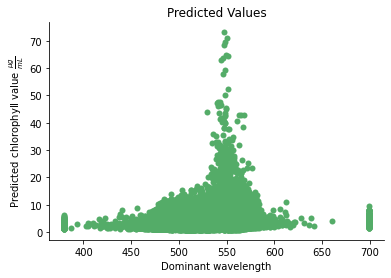

In [119]:
sb.scatterplot(
    data=predictions,
    x='dwl',
    y='pred_chlorophyll',
    color='xkcd:algae',
    linewidth=0
)
sb.despine()
plt.title('Predicted Values')
plt.xlabel('Dominant wavelength')
plt.ylabel('Predicted chlorophyll value $\\frac{\\mu g}{mL}$')
plt.savefig('figures/predictions.png', dpi=200, bbox_inches='tight')
plt.show()

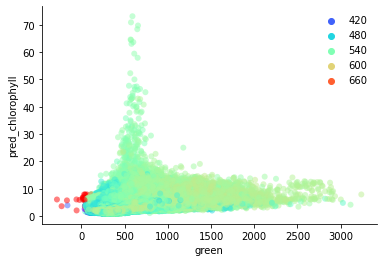

In [116]:
sb.scatterplot(
    data=predictions,
    x='green',
    y='pred_chlorophyll',
    hue='dwl',
    palette='rainbow',
    linewidth=0,
    alpha=0.5
)
plt.legend(frameon=False)
sb.despine()
plt.show()